In [ ]:
# import packages.
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Load Train & Test data.

In [ ]:
train_images = np.load('/content/drive/My Drive/intel_train_images.npy')
train_labels = np.load('/content/drive/My Drive/intel_train_labels.npy')
print(train_images.shape)
print(train_labels.shape)

(990, 150, 150, 3)
(990,)


In [ ]:
test_images = np.load('/content/drive/My Drive/intel_test_images.npy', allow_pickle=True)
test_labels = np.load('/content/drive/My Drive/intel_test_labels.npy')
print(test_images.shape)
print(test_labels.shape)

(827,)
(827,)


#### The shape of test_images we got is (827, ) because the shape of some of the images in the images list are not equal to (150,150,3) so we have to remove those items.

#### Remove those items from test_images whose shape is not equal to (150,150,3). Those items have shape like 25558 so we have to remove those items.

In [ ]:
Test_images =[]
remove_items =[]
for i in range(len(test_images)):
  if test_images[i].shape != (150,150,3):
    remove_items.append(i)
    continue
  else:
    img = test_images[i]  
    Test_images.append(img)
Test_images = np.array(Test_images)
Test_images.shape  

(825, 150, 150, 3)

#### Now everything looks fine.

In [ ]:
remove_items

[144, 359]

### Remove labels corresponding to the bad items.

In [ ]:
Test_labels = []
for i in range(827):
  if i in remove_items:
    continue
  else:
    Test_labels.append(test_labels[i])
len(Test_labels)    

825

In [ ]:
del test_images, test_labels

In [ ]:
label_to_name ={0:'buildings', 1:'forest', 2:'mountain', 3:'sea', 4:'street'}

In [ ]:
#shuffle the dataset.
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels)
Test_images, Test_labels = shuffle(Test_images, Test_labels)

### Some images and their class label.

Label name = buildings


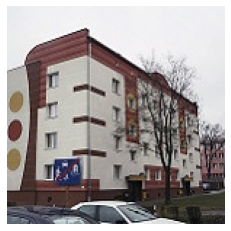

Label name = forest


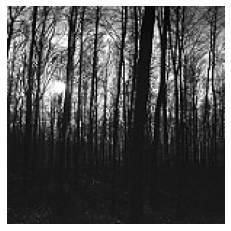

Label name = mountain


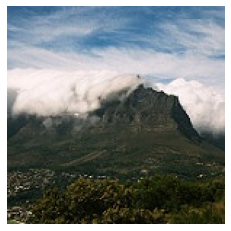

Label name = sea


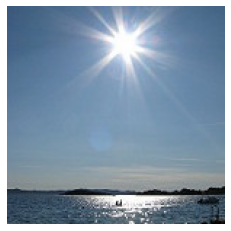

Label name = street


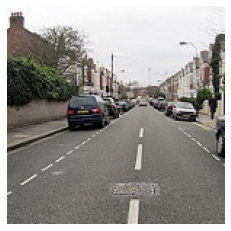

In [ ]:
for i in [100, 300, 500, 700, 900]:
  print('Label name =', label_to_name[train_labels[i]])
  plt.imshow(train_images[i])
  plt.axis('off')
  plt.show()

### Create data augmentation because we have lery less amount of train data points.
### While Deep Learning model need large dataset for training to build a robust model. 

In [ ]:
seed =42
image_datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.5, rotation_range=20, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')
image_datagen_train.fit(train_images, augment=True, seed=seed)

image_datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.5, rotation_range=20, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')
image_datagen_test.fit(Test_images, augment=True, seed=seed)

In [ ]:
# one hot encoding of class labels.
Train_labels = tf.keras.utils.to_categorical(train_labels, 5)
Test_labels = tf.keras.utils.to_categorical(Test_labels, 5)

### Load a pretrained InceptionV3 model for transfer learning.

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150,150,3))
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
# Freeze all the layers except BatchNormalization layers.
for layer in base_model.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
    layer.trainable = True
  else:
    layer.trainable = False  

In [ ]:
model=tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5, 'softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 92165     
Total params: 21,894,949
Trainable params: 109,381
Non-trainable params: 21,785,568
_________________________________________________________________


In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# Callbacks.
earlystopper = tf.keras.callbacks.EarlyStopping(patience=6)
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Intel_Model', verbose=1, save_best_only=True)

In [ ]:
# Train.
result = model.fit(image_datagen_train.flow(train_images, Train_labels, batch_size=32), steps_per_epoch=len(train_images)/32, epochs=50, validation_data=image_datagen_test.flow(Test_images, Test_labels), callbacks=[earlystopper, checkpointer])

Epoch 1/50
31/30 [==============================] - ETA: 0s - loss: 1.6094 - accuracy: 0.3152
Epoch 00001: val_loss improved from inf to 1.25330, saving model to /content/drive/My Drive/Intel_Model
INFO:tensorflow:Assets written to: /content/drive/My Drive/Intel_Model/assets
31/30 [==============================] - 72s 2s/step - loss: 1.6094 - accuracy: 0.3152 - val_loss: 1.2533 - val_accuracy: 0.5261
Epoch 2/50
31/30 [==============================] - ETA: 0s - loss: 1.0973 - accuracy: 0.5818
Epoch 00002: val_loss improved from 1.25330 to 0.96245, saving model to /content/drive/My Drive/Intel_Model
INFO:tensorflow:Assets written to: /content/drive/My Drive/Intel_Model/assets
31/30 [==============================] - 68s 2s/step - loss: 1.0973 - accuracy: 0.5818 - val_loss: 0.9625 - val_accuracy: 0.6703
Epoch 3/50
31/30 [==============================] - ETA: 0s - loss: 0.9057 - accuracy: 0.6818
Epoch 00003: val_loss improved from 0.96245 to 0.87250, saving model to /content/drive/My Dr

KeyboardInterrupt: ignored

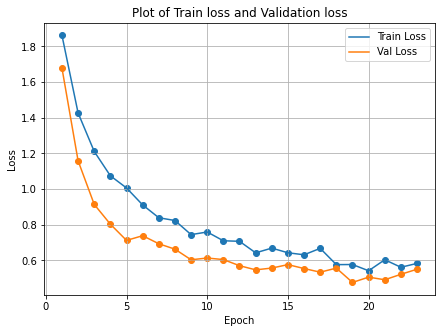

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(1, len(result.history['loss'])+1), result.history['loss'], label = 'Train Loss')
plt.scatter(range(1, len(result.history['loss'])+1), result.history['loss'])
plt.plot(range(1, len(result.history['loss'])+1), result.history['val_loss'], label = 'Val Loss')
plt.scatter(range(1, len(result.history['loss'])+1), result.history['val_loss'])
plt.title('Plot of Train loss and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

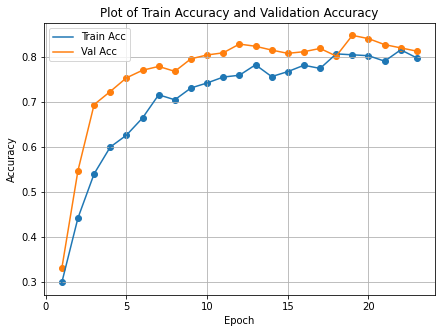

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(1, len(result.history['accuracy'])+1), result.history['accuracy'], label = 'Train Acc')
plt.scatter(range(1, len(result.history['loss'])+1), result.history['accuracy'])
plt.plot(range(1, len(result.history['loss'])+1), result.history['val_accuracy'], label = 'Val Acc')
plt.scatter(range(1, len(result.history['loss'])+1), result.history['val_accuracy'])
plt.title('Plot of Train Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
trained_model = tf.keras.models.load_model('/content/drive/My Drive/Intel_Model') # Load trained model.

In [ ]:
trained_model.evaluate(train_images, Train_labels, batch_size=32)

31/31 [==============================] - 2s 79ms/step - loss: 0.2091 - accuracy: 0.9495


[0.20905184745788574, 0.9494949579238892]

In [ ]:
trained_model.evaluate(Test_images, Test_labels, batch_size=32)

26/26 [==============================] - 2s 80ms/step - loss: 0.3469 - accuracy: 0.9055


[0.34691447019577026, 0.9054545164108276]

In [ ]:
# for ploting confusing matrix , precision matrix and recall matrix.
from sklearn.metrics import confusion_matrix
 
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2,3,4]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(7,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
 
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(7,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(7,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### Confusion Matrix, Precision Matrix and Recall Matrin for train data.

-------------------- Confusion matrix --------------------


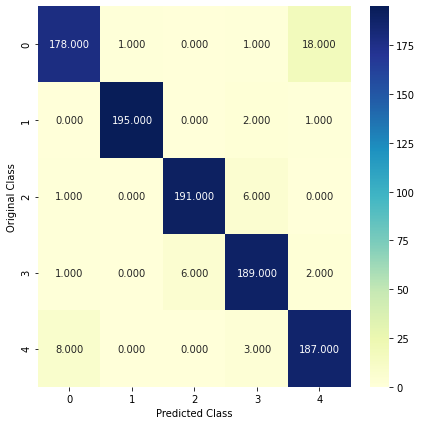

-------------------- Precision matrix (Columm Sum=1) --------------------


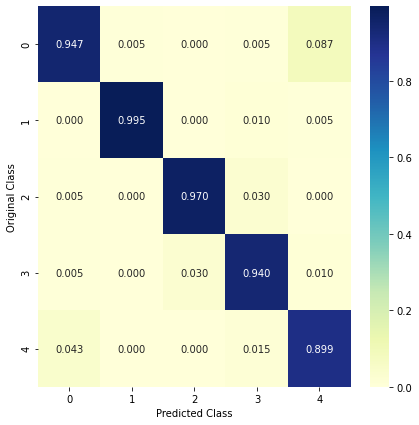

-------------------- Recall matrix (Row sum=1) --------------------


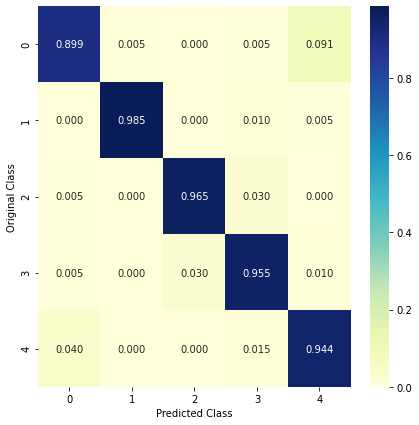

In [ ]:
labels = []
for i in Train_labels:
  labels.append(np.argmax(i))
predictions = trained_model.predict(train_images, batch_size=32)
pred =[]
for i in predictions:
  pred.append(np.argmax(i))  
plot_confusion_matrix(labels, pred)

### Confusion Matrix, Precision Matrix and Recall Matrix for Test data.

-------------------- Confusion matrix --------------------


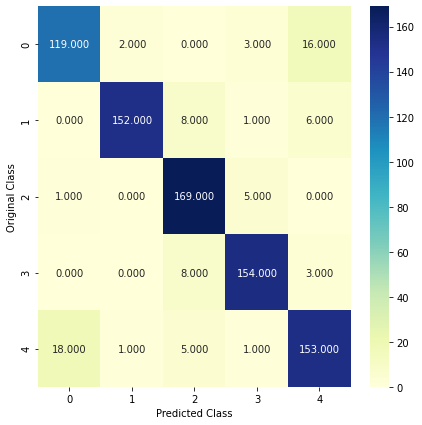

-------------------- Precision matrix (Columm Sum=1) --------------------


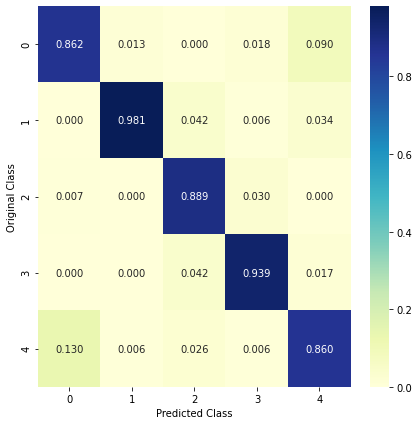

-------------------- Recall matrix (Row sum=1) --------------------


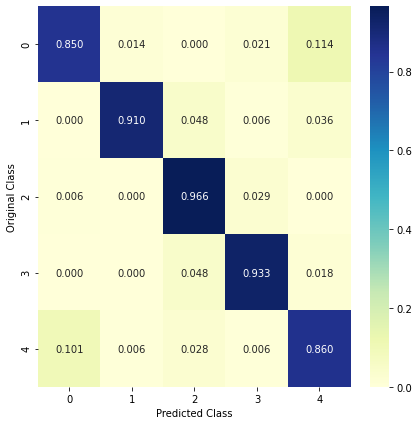

In [ ]:
labels = []
for i in Test_labels:
  labels.append(np.argmax(i))
predictions = trained_model.predict(Test_images, batch_size=32)
pred =[]
for i in predictions:
  pred.append(np.argmax(i))  
plot_confusion_matrix(labels, pred)

 - It shows that all class labels are w

Actual label name = buildings
Predicted label name = buildings , With probability score = 0.46


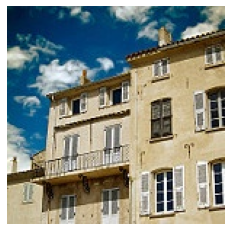

Actual label name = mountain
Predicted label name = mountain , With probability score = 0.99


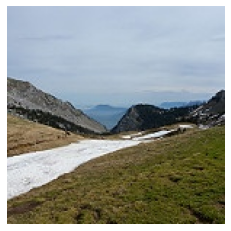

Actual label name = mountain
Predicted label name = mountain , With probability score = 0.86


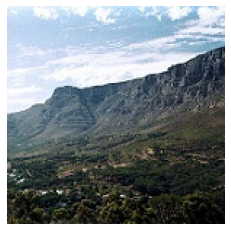

Actual label name = mountain
Predicted label name = mountain , With probability score = 0.87


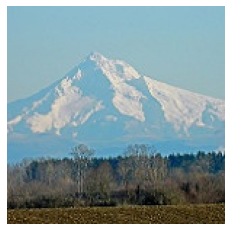

Actual label name = street
Predicted label name = street , With probability score = 1.0


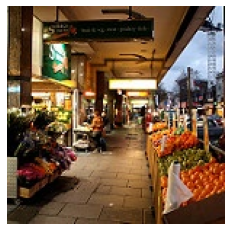

In [ ]:
for i in np.random.randint(1,800,5):
  print('Actual label name =', label_to_name[np.argmax(Test_labels[i])])
  pred = trained_model.predict(Test_images[i].reshape(1,150,150,3))
  print('Predicted label name =', label_to_name[np.argmax(pred)], ', With probability score =',np.round(np.max(pred),2))
  plt.imshow(Test_images[i])
  plt.axis('off')
  plt.show()

## Summary:

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ('On Train data', 'On Test data')
table.add_row(('Train Loss = 0.21', 'Test Loss = 0.34'))
table.add_row(('Train Accuracy = 0.95', 'Test Accuracy = 0.91'))
print(table)

+-----------------------+----------------------+
|     On Train data     |     On Test data     |
+-----------------------+----------------------+
|   Train Loss = 0.21   |   Test Loss = 0.34   |
| Train Accuracy = 0.95 | Test Accuracy = 0.91 |
+-----------------------+----------------------+
